# Final task:  
# Dimensionality reduction via principal component analysis

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import random
import copy
import numpy as np
import scipy as scy
from tqdm.notebook import trange, tqdm
import time 
from scipy.stats import maxwell

#used for the video
import subprocess
import glob
import os

## Introduction: 

## Task I: Implementation

Monte Carlo (MC) method with Metropolis algorithm that samples a 2D energy surface with:

$$U(x,y) = k_{b}T (0.28(0.25(a·x+b·y)^{4}+0.1(a·x+b·y)^{3} −3.24(a·x+b·y)^{2} +6.856(a·y−b·x)^{2})+3.5) $$ 

with $a = 0.809$ and $b = 0.588$.

In [102]:
a = 0.809
b = 0.588

In [105]:
def Potential_energy (x,y):
    ax_plus_by = a*x + b*y
    ay_minus_bx =a*y - b*x
    
    U = k_b * Temp * (0.28*( 0.25*ax_plus_by**4 + 0.1*ax_plus_by**3 - 3.24*ax_plus_by**2 + 6.856*ay_minus_bx**2)+3.5)
    return U

In [65]:
def Move(x,y): 
    #Calculate U1
    U_1 = Potential_energy(x,y)
    
    #Move by dR = 0.01 nm in a random direction
    angle = np.random.uniform(0,2*np.pi)
    dx = np.sin(angle)*dR
    dy = np.cos(angle)*dR
    
    #Calculate U2
    U_2 = Potential_energy(x+dx, y+dy)
    
    if U_1 > U_2:
        #accept move
        return True, x+dx , y+dy, U_2
    
    else :
        P = np.exp(-(U_2 - U_1)/(k_b*Temp))
        q = np.random.uniform(0,1)
        if q < P:
            #accept move
            return True, x+dx , y+dy, U_2
        else :
            #Discard move
            return False, x, y, U_1

* Could do the Pand q in ln to simplify

## Task II: Simulation

In [66]:
Temp = 300 #K

#step size
dR = 0.01 #nm

#Initial position #nm
x_0 = 2
y_0 = 2

# Number of MC samples = 1000000
Nbr_MC = 2000000

#k_b_mol = 8.314462 #J⋅K^(-1).mol^(-1)
k_b = 1.380649e-23 #J.K-1
Na = 6.02214086e23 #mol-1

In [67]:
x_list = [x_0] + [0]*Nbr_MC
y_list = [y_0] + [0]*Nbr_MC
U_list = [Potential_energy(x_0,y_0)] + [0]*Nbr_MC

#Number of accepted moves
move_Nbr = 0

while move_Nbr < Nbr_MC :
    if (100*move_Nbr/Nbr_MC)%5 == 0 :
        print(str(100 * move_Nbr/Nbr_MC)[:3])
    check_value, x, y, U = Move( x_list[move_Nbr], y_list[move_Nbr])
    if check_value == True :
        move_Nbr += 1
        x_list[move_Nbr] = x
        y_list[move_Nbr] = y
        U_list[move_Nbr] = U
        
print('Done')

0.0
5.0
10.
15.
20.
25.
30.
35.
40.
45.
50.
55.
60.
65.
70.
75.
80.
85.
90.
95.
Done


['2.2e-22', '5.8e-21', '1.1e-20', '1.7e-20', '2.2e-20', '2.8e-20']


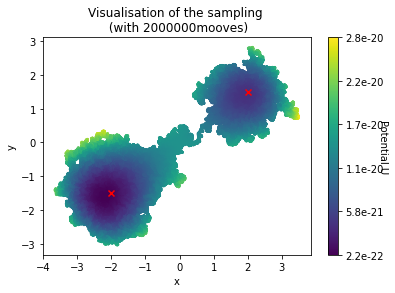

In [80]:
plt.scatter(x_list, y_list, c = U_list, s=3)
plt.scatter([2,-2], [1.5,-1.5], c = 'red', marker='x',label='Minima')

plt.xlabel('x')
plt.ylabel('y')
t = 'Visualisation of the sampling \n (with ' + str(Nbr_MC) + 'mooves)'
plt.title(t)

cbar = plt.colorbar()

U_ticks = np.linspace(min(U_list), max(U_list), 6)
U_ticks = [str(U_ticks[i])[0:3] + str(U_ticks[i])[-4:] for i in range(len(U_ticks))]
cbar.ax.set_yticklabels(U_ticks)

a=cbar.set_label('Potential U', rotation=270)

In [81]:
np.savez('save.npz', x_list, y_list, U_list)

## Task III: Sampling

Free energy :
$$\Delta G(x,y) = -k_{b}T ln(P(x,y))$$
$$ = (U2-U1) = \Delta U$$

With :
    $$ln(P) = - \frac{(U2-U1)}{k_{b}T}$$

In [106]:
lnP_list = [0]* Nbr_MC
for i in trange (1, Nbr_MC):
    U_1 = Potential_energy( x_list[i-1], y_list[i-1])
    U_2 = Potential_energy( x_list[i], y_list[i])
    lnP = abs((U_2 - U_1))
    lnP_list[i-1] = lnP

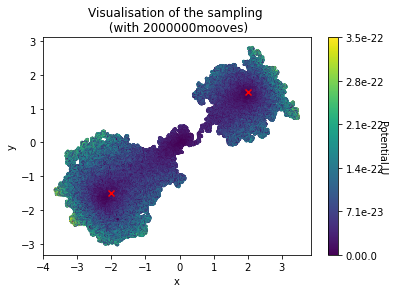

In [107]:
plt.scatter(x_list[1:], y_list[1:], c = lnP_list[:], s=3)
plt.scatter([2,-2], [1.5,-1.5], c = 'red', marker='x',label='Minima')

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-4,4)
plt.ylim(-4,4)

t = 'Visualisation of the sampling \n (with ' + str(Nbr_MC) + 'mooves)'
plt.title(t)

cbar = plt.colorbar()

lnP_ticks = np.linspace(min(lnP_list), max(lnP_list), 6)
lnP_ticks = [str(lnP_ticks[i])[0:3] + str(lnP_ticks[i])[-4:] for i in range(len(lnP_ticks))]
cbar.ax.set_yticklabels(lnP_ticks)

a=cbar.set_label('Potential U', rotation=270)

## Task IV: PCA

**Means**

In [108]:
mean_x = np.mean(x_list)
mean_y = np.mean(y_list)

**Variances**

In [109]:
var_x = np.var(x_list)
var_y = np.var(y_list)

**Covariances and matrix $\sigma_{ij}$**

$ \sigma_{ij} = 
\begin{pmatrix}
var(x) & cov(x,y)\\
cov(y,x) & var(y)
\end{pmatrix}$

In [1]:
sigma = np.cov(x_list, y_list)
print('𝜎_ij =  \n',sigma)

NameError: name 'np' is not defined

**Eigenvalues $\lambda_{k}$ and eigenvectors $\vec{e}_{\lambda k}$**

In [136]:
eig_values, eig_vectors = np.linalg.eig(sigma)

eig_vec_1 = eig_vectors[:,0]
eig_val_1 = eig_values[0]
eig_vec_2 = eig_vectors[:,1]
eig_val_2 = eig_values[1]

print('Lambda1 = ', eig_val_1, 'with eigenvector e1: ', eig_vec_1)
print('Lambda2 = ', eig_val_2, 'with eigenvector e2: ',eig_vec_2)


Lambda1 =  4.3780025814984915 with eigenvector e1:  [0.82100187 0.5709255 ]
Lambda2 =  0.2306804041095054 with eigenvector e2:  [-0.5709255   0.82100187]


The eigenvectors match the data as expected, as we can see that our first vector has the same direction as the connecting axis between the two minimas and that our second vector is perpendicular to the first our as expected.

In [ ]:
plt.plot([eig_vec_1[0]*(-3),eig_vec_1[0]*(3)], [eig_vec_1[1]*(-3),eig_vec_1[1]*(3)], label='Eingenvector 1')
plt.plot([eig_vec_2[0]*(-3),eig_vec_2[0]*(3)], [eig_vec_2[1]*(-3),eig_vec_2[1]*(3)], label='Eingenvector 2')
plt.xlim(-4,4)
plt.ylim(-4,4)

## Task V: Interpretation

**Angle $\theta$ between the eigenvector $\vec{e}_{λ1}$**

In [147]:
Theta = np.arctan(eig_vec_1[0]/eig_vec_1[1])
print('Theta ~', str(round(Theta/np.pi, 3)),'𝜋')

Theta ~ 0.307 𝜋


The angle $\theta$ found is close to $\frac{\pi}{3}$, which seems correct compared to the plot of the potential displayed in Task II.

**Clockwise rotation matrix R**

$ R (\theta) = 
\begin{pmatrix}
Cos(\theta) & Sin(\theta)\\
-Sin(\theta) & Cos(\theta)
\end{pmatrix}$

$ R \begin{pmatrix} x \\ y \end{pmatrix} = \begin{pmatrix} x' \\ y' \end{pmatrix}$

For $x'$ and $y'$ being the data in the rotated frame.

In [149]:
R = np.array([[np.cos(Theta), np.sin(Theta)],[- np.sin(Theta), np.cos(Theta)]])

-0.8210018713998517


**Calculate the data in the new frame**

In [151]:
x_rot_list = [R[0,0]*x_list[i] + R[0,1]*y_list[i] for i in trange(len(x_list))]
y_rot_list = [R[1,0]*x_list[i] + R[1,1]*y_list[i] for i in trange(len(x_list))]

In [156]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

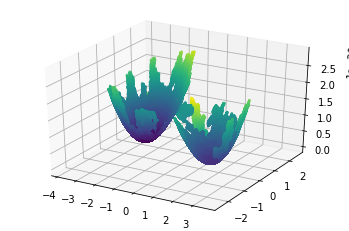

In [169]:
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.scatter(x_rot_list, y_rot_list, U_list, c=U_list, marker='o', s=2)


U_ticks = np.linspace(min(U_list), max(U_list), 6)
U_ticks = [str(U_ticks[i])[0:3] + str(U_ticks[i])[-4:] for i in range(len(U_ticks))]

#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(U_ticks)

#cbar.ax.set_yticklabels(U_ticks)

#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

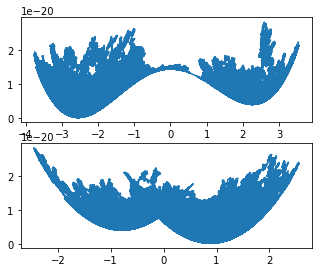

In [170]:
plt.subplot(211)
plt.plot(x_rot_list, U_list)
plt.subplot(212)
plt.plot(y_rot_list, U_list)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.show()

* "the histogram of Task III" is it not a plot that we are expecting? 
* $\Delta G$ equivalent to U ???